In [1]:
from liblet import Transition, Automaton, Grammar, Production, Item, Derivation, ProductionGraph, Stack, Queue, StateTransitionGraph, closure, dod2table, iter2table, peek, warn

# LR(0)

In [8]:
G = Grammar.from_string("""
E -> E - T | T
T -> n | ( E )
""")
G

Grammar(N={E, T}, T={(, ), -, n}, P=(E -> E - T, E -> T, T -> n, T -> ( E )), S=E)

In [3]:
A, α = G.P[0] 
item = Item(A, α)
item

E -> •E - T

In [4]:
for X in 'E', '-', 'T':
    item = item.advance(X)
    print(item, item.symbol_after_dot())

E -> E•- T -
E -> E -•T T
E -> E - T• None


In [5]:
@closure
def ε_closure(items, G):
    added = set()
    for item in items:
        X = item.symbol_after_dot()
        if X is None: continue
        added |= {Item(X, β) for β in G.alternatives(X)}
    return tuple(sorted(set(items) | added))

In [6]:
def q0(G):
    return ε_closure([Item(G.S, β) for β in G.alternatives(G.S)], G)

q0(G)

(E -> •E - T, E -> •T, T -> •( E ), T -> •n)

In [7]:
def δ(items, X, G):
    return ε_closure([item.advance(X) for item in items if item.advance(X)], G)

δ(q0(G), '(', G)

(E -> •E - T, E -> •T, T -> •( E ), T -> (•E ), T -> •n)

Trasformo $G$ in $G_{\#}$ aggiungendo la produzione $S_{\#}\to S\#$ a $G$ dove $S_{\#}$ è lo *start symbol* di $G_{\#}$, questo da a $L(G_{\#}) = \{w\# | w \in L(G)\}$ la *prefix property*.

In [12]:
def add_eoi(G):
    return Grammar(G.N | {'S#'}, G.T | {'#'}, G.P + (Production('S#', (G.S, '#')), ), 'S#')

In [13]:
def compute_lr0_automaton(G):
    
    states = set([q0(G)])
    transitions = []
    q = Queue([q0(G)])
    while q:
        items = q.dequeue()
        for X in G.T | G.N:
            next_items = δ(items, X, G)
            if not next_items: continue
            transitions.append(Transition(items, X, next_items))
            if next_items not in states: 
                states.add(next_items)
                q.enqueue(next_items)

    return Automaton(
        states,
        G.T | G.N,
        transitions,
        q0(G),
        set(state for state in states if len(state) == 1 and peek(state).symbol_after_dot() is None)
    )

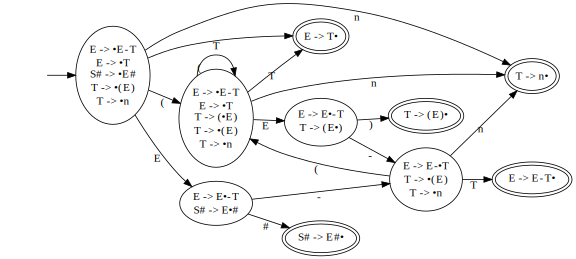

In [14]:
lr0a = compute_lr0_automaton(add_eoi(G))
StateTransitionGraph.from_automaton(lr0a, large_labels = True)

## GOTO e ACTIONS

In [15]:
states = sorted(lr0a.N)
states 

[(E -> •E - T, E -> •T, S# -> •E #, T -> •( E ), T -> •n),
 (E -> •E - T, E -> •T, T -> •( E ), T -> (•E ), T -> •n),
 (E -> E•- T, S# -> E•#),
 (E -> E•- T, T -> ( E•)),
 (E -> E -•T, T -> •( E ), T -> •n),
 (E -> E - T•,),
 (E -> T•,),
 (S# -> E #•,),
 (T -> ( E )•,),
 (T -> n•,)]

In [16]:
index_of = states.index

goto = {}
for frm in states:
    goto[index_of(frm)] = {}
    for X in sorted(lr0a.T):
        to = lr0a.δ(frm, X)
        if to: 
            to = peek(to)
            goto[index_of(frm)][X] = index_of(to)
            
dod2table(goto)

In [17]:
actions = []
for state in states:
    if len(state) == 1: 
        A, α, _ = state[0]
        actions.append(Production(A, α))
    else:
        actions.append(None)

iter2table(actions)

## PDA

### Solo parsing

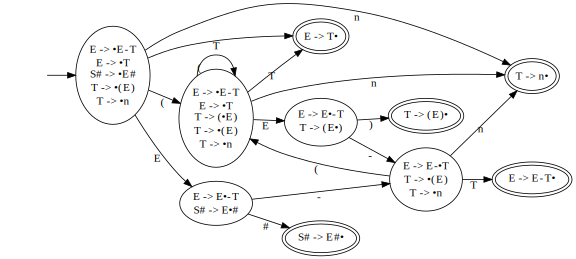

In [18]:
StateTransitionGraph.from_automaton(lr0a, large_labels = True)

In [21]:
def lr0parse(lr0a, text):

    rest = tuple(text.split()) + ('#', )
    s = Stack([lr0a.q0])

    while True:
        top = s.peek()
        if top in lr0a.F: # REDUCE
            N, α, _ = peek(top)
            if N == 'S#' and not rest: return True
            for _ in range(len(α)): s.pop()
            nxt = peek(lr0a.δ(s.peek(), N))
        else:
            if not rest: # SHIFT
                warn('Unexpected end of input')
                return None
            token, rest = rest[0], rest[1:]
            nxt = peek(lr0a.δ(top, token))
            if nxt is None: 
                warn('Unexpected token {}'.format(token))
                return None
        s.push(nxt)

In [22]:
lr0parse(lr0a, 'n - n - n')

True

In [23]:
lr0parse(lr0a, 'n - ( - n')

Unexpected token -


### Tenendo traccia della derivazione

In [24]:
def lr0parse(G, lr0a, text, show = False):

    G = add_eoi(G)
    
    rest = tuple(text.split()) + ('#', )
    s = Stack([lr0a.q0])
    rm_steps = []

    while True:
        top = s.peek()
        if top in lr0a.F:
            N, α, _ = peek(top)
            if N == 'S#' and not rest: 
                return rm_steps
            prod = Production(N, α)
            rm_steps.append(G.P.index(prod))
            if show: print('reduce', prod)
            for _ in range(len(α)): s.pop()
            nxt = peek(lr0a.δ(s.peek(), N))
        else:
            if not rest:
                warn('Unexpected end of input')
                return None
            token, rest = rest[0], rest[1:]
            if show: print('shift', token)
            nxt = peek(lr0a.δ(top, token))
            if nxt is None: 
                warn('Unexpected token {}'.format(token))
                return None
        s.push(nxt)

shift n
reduce T -> n
reduce E -> T
shift -
shift n
reduce T -> n
reduce E -> E - T
shift -
shift n
reduce T -> n
reduce E -> E - T
shift #


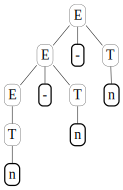

In [25]:
rm_steps = lr0parse(G, lr0a, 'n - n - n', True)

if rm_steps:
    d = Derivation(G)
    for rm in reversed(rm_steps): d = d.rightmost(rm)
    display(ProductionGraph(d))

# Conflitti

## Shift/reduce

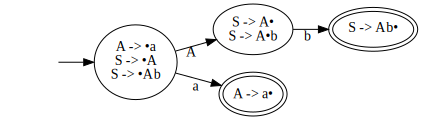

In [19]:
Gsr = Grammar.from_string("""
S -> A b | A
A -> a
""")
lr0asr = compute_lr0_automaton(Gsr)
StateTransitionGraph.from_automaton(lr0asr, large_labels = True)

## Reduce/Reduce

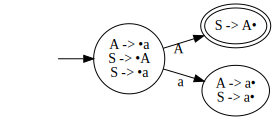

In [20]:
Grr = Grammar.from_string("""
S -> A | a
A -> a
""")
lr0arr = compute_lr0_automaton(Grr)
StateTransitionGraph.from_automaton(lr0arr, large_labels = True)